In [1]:
import numpy as np
import torch
import torch.nn as nn
from PQC import getHaar
import matplotlib.pyplot as plt
from QuantumState import *
from getPQCvector import *
from PQC_Loss import *

In [2]:
class PQCNN(nn.Module):
    def __init__(self,qubits=2,num=100,bins=250):
        super(PQCNN,self).__init__()
        self.fc1 = nn.Linear(6,6,bias=True)
        self.fc1.weight.data = torch.eye(6)
        self.fc1.bias.data = torch.zeros(6)
        self.activation = nn.Tanh().double()
        self.fc2 = nn.Linear(6,6,bias=True)
        self.fc2.weight.data = torch.eye(6)*np.pi*2
        self.fc2.bias.data = torch.zeros(6)
        self.qubits = qubits
        self.num = num
        self.bins = bins
        self.haar_hist = torch.from_numpy(getHaar(reps=self.num**2,bins=self.bins,qubits=self.qubits)).float()
        self.haar_hist_detail = torch.from_numpy(getHaar(reps=(10*self.num)**2,bins=self.bins,qubits=self.qubits)).float()
        self.criterion = nn.KLDivLoss(reduction='sum')
        self.optimizer = torch.optim.Adagrad(self.parameters())
        self.losses = []
        self.expr = []
        self.float()
    def getPQCvector(self,theta):
        q = QuantumState(2)
        q.RX(0,theta[0].view(1,))
        q.RX(1,theta[1].view(1,))
        q.RZ(0,theta[2].view(1,))
        q.RZ(1,theta[3].view(1,))
        q.CRX(0,1,theta[4].view(1,))
        q.CRX(1,0,theta[5].view(1,))
        v = q.state.view(-1,1)
        return v
    def getFparallel(self,num):
        input1 = torch.rand(num,6)*2*np.pi
        input2 = torch.rand(num,6)*2*np.pi
        y1 = self.forward(input1)
        y2 = self.forward(input2)
        v1 = []
        for i in range(num):
            v1.append(self.getPQCvector(y1[i]).view(-1))
        V1 = torch.stack(v1,0)
        v2 = []
        for i in range(num):
            v2.append(self.getPQCvector(y2[i]).view(-1))
        V2 = torch.stack(v2,0)
        F = torch.matmul(torch.conj(V1),torch.transpose(V2,0,1))
        F = torch.abs(F)**2
        F = torch.flatten(F)
        return F
    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x
    def loss(self,hist):
        loss = self.criterion(torch.log(hist),self.haar_hist)
        loss = loss.type(torch.FloatTensor)
        return loss
    def plotdist(self,verbose=0):
        Fidelity = self.getFparallel(self.num*10)
        hist = torch.histc(Fidelity,min=0,max=1,bins=self.bins)/((10*self.num)**2)
        loss = self.criterion(torch.log(torch.where(hist!=0,hist,self.haar_hist_detail)),self.haar_hist_detail)
        if verbose == 0:
            self.expr.append(loss.data.item())
        if verbose == 1:
            plt.title("Expr: {0}".format(loss.data.item()))
            x = np.linspace(0,1,self.bins)
            plt.plot(x,torch.detach(hist/self.bins))
            plt.plot(x,torch.detach(self.haar_hist_detail/self.bins))
            plt.figure()
    def train(self,epoch=1000):
        for ep in range(epoch):
            Fidelity = self.getFparallel(self.num)
            hist = histgauss(Fidelity,bins=250,sigma=1/self.bins)
            cost = self.loss(hist)
            self.losses.append(cost.data.item())
            self.optimizer.zero_grad()
            cost.backward()
            self.optimizer.step()
            if ep%100 == 99:
                print("epoch: ",ep+1, "loss: ",cost)
                self.plotdist(verbose=0)
            if ep%1000 == 999:
                self.plotdist(verbose=1)



epoch:  100 loss:  tensor(0.0737, grad_fn=<KlDivBackward>)
epoch:  200 loss:  tensor(0.0245, grad_fn=<KlDivBackward>)
epoch:  300 loss:  tensor(0.0185, grad_fn=<KlDivBackward>)
epoch:  400 loss:  tensor(0.0147, grad_fn=<KlDivBackward>)
epoch:  500 loss:  tensor(0.0120, grad_fn=<KlDivBackward>)
epoch:  600 loss:  tensor(0.0148, grad_fn=<KlDivBackward>)
epoch:  700 loss:  tensor(0.0094, grad_fn=<KlDivBackward>)
epoch:  800 loss:  tensor(0.0086, grad_fn=<KlDivBackward>)
epoch:  900 loss:  tensor(0.0085, grad_fn=<KlDivBackward>)
epoch:  1000 loss:  tensor(0.0068, grad_fn=<KlDivBackward>)
epoch:  1100 loss:  tensor(0.0098, grad_fn=<KlDivBackward>)
epoch:  1200 loss:  tensor(0.0067, grad_fn=<KlDivBackward>)
epoch:  1300 loss:  tensor(0.0071, grad_fn=<KlDivBackward>)
epoch:  1400 loss:  tensor(0.0074, grad_fn=<KlDivBackward>)
epoch:  1500 loss:  tensor(0.0082, grad_fn=<KlDivBackward>)
epoch:  1600 loss:  tensor(0.0065, grad_fn=<KlDivBackward>)
epoch:  1700 loss:  tensor(0.0056, grad_fn=<KlDiv

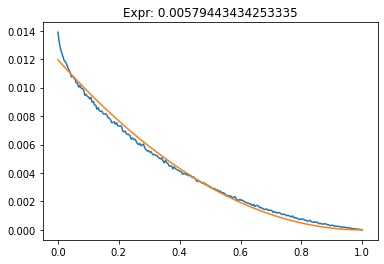

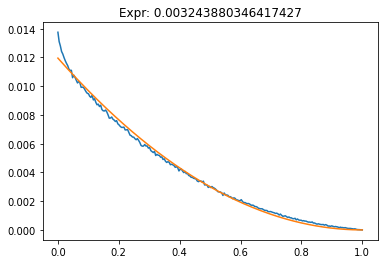

<Figure size 432x288 with 0 Axes>

In [3]:
pqc = PQCNN()
pqc.train(2000)

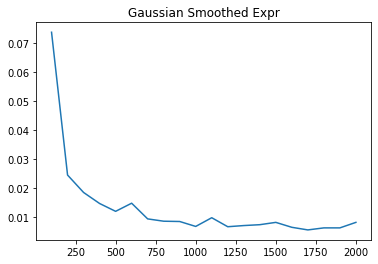

In [5]:
x = [100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000]
losses = [0.0737,0.0245,0.0185,0.0147,0.0120,0.0148,0.0094,0.0086,0.0085,0.0068,0.0098,0.0067,0.0071,0.0074,0.0082,0.0065,0.0056,0.0063,0.0063,0.0082]
plt.title("Gaussian Smoothed Expr")
plt.plot(x,losses)

In [4]:
print(pqc.losses)
print(pqc.expr)

6415701806545, 0.007456313353031874, 0.009194733574986458, 0.00773719884455204, 0.007497052196413279, 0.010152166709303856, 0.009224910289049149, 0.006343850865960121, 0.009989585727453232, 0.00686628557741642, 0.006693257484585047, 0.007857607677578926, 0.007459872402250767, 0.0073641943745315075, 0.008721135556697845, 0.007000646088272333, 0.009594639763236046, 0.007596906740218401, 0.00928176287561655, 0.008062093518674374, 0.008117030374705791, 0.009359283372759819, 0.010343793779611588, 0.006794845685362816, 0.00881837960332632, 0.008666766807436943, 0.007461010478436947, 0.014977885410189629, 0.006969138514250517, 0.008592290803790092, 0.010326898656785488, 0.00782021600753069, 0.006070682313293219, 0.008104700595140457, 0.007439195644110441, 0.009933695197105408, 0.008270632475614548, 0.009290332905948162, 0.00854977872222662, 0.007050031796097755, 0.011722680181264877, 0.00656599085777998, 0.00836719200015068, 0.009440592490136623, 0.007325411308556795, 0.0062860408797860146, 0

epoch:  100 loss:  tensor(0.0085, grad_fn=<KlDivBackward>)
epoch:  200 loss:  tensor(0.0104, grad_fn=<KlDivBackward>)
epoch:  300 loss:  tensor(0.0060, grad_fn=<KlDivBackward>)
epoch:  400 loss:  tensor(0.0099, grad_fn=<KlDivBackward>)
epoch:  500 loss:  tensor(0.0122, grad_fn=<KlDivBackward>)
epoch:  600 loss:  tensor(0.0076, grad_fn=<KlDivBackward>)
epoch:  700 loss:  tensor(0.0105, grad_fn=<KlDivBackward>)
epoch:  800 loss:  tensor(0.0073, grad_fn=<KlDivBackward>)
epoch:  900 loss:  tensor(0.0071, grad_fn=<KlDivBackward>)
epoch:  1000 loss:  tensor(0.0073, grad_fn=<KlDivBackward>)


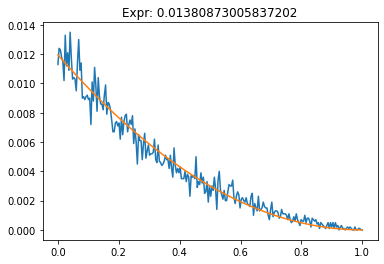

<Figure size 432x288 with 0 Axes>

In [4]:
pqc.train(1000)

epoch:  100 loss:  tensor(0.0093, grad_fn=<KlDivBackward>)
epoch:  200 loss:  tensor(0.0070, grad_fn=<KlDivBackward>)
epoch:  300 loss:  tensor(0.0081, grad_fn=<KlDivBackward>)
epoch:  400 loss:  tensor(0.0084, grad_fn=<KlDivBackward>)
epoch:  500 loss:  tensor(0.0093, grad_fn=<KlDivBackward>)
epoch:  600 loss:  tensor(0.0076, grad_fn=<KlDivBackward>)
epoch:  700 loss:  tensor(0.0072, grad_fn=<KlDivBackward>)
epoch:  800 loss:  tensor(0.0048, grad_fn=<KlDivBackward>)
epoch:  900 loss:  tensor(0.0070, grad_fn=<KlDivBackward>)
epoch:  1000 loss:  tensor(0.0054, grad_fn=<KlDivBackward>)


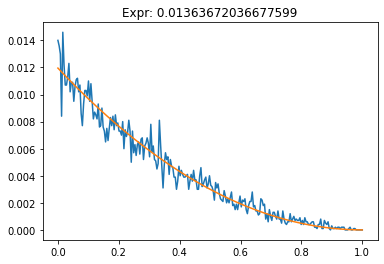

<Figure size 432x288 with 0 Axes>

In [5]:
pqc.train(1000)

epoch:  100 loss:  tensor(0.0066, grad_fn=<KlDivBackward>)
epoch:  200 loss:  tensor(0.0048, grad_fn=<KlDivBackward>)
epoch:  300 loss:  tensor(0.0062, grad_fn=<KlDivBackward>)
epoch:  400 loss:  tensor(0.0058, grad_fn=<KlDivBackward>)
epoch:  500 loss:  tensor(0.0073, grad_fn=<KlDivBackward>)
epoch:  600 loss:  tensor(0.0059, grad_fn=<KlDivBackward>)
epoch:  700 loss:  tensor(0.0049, grad_fn=<KlDivBackward>)
epoch:  800 loss:  tensor(nan, grad_fn=<KlDivBackward>)
epoch:  900 loss:  tensor(nan, grad_fn=<KlDivBackward>)
epoch:  1000 loss:  tensor(nan, grad_fn=<KlDivBackward>)


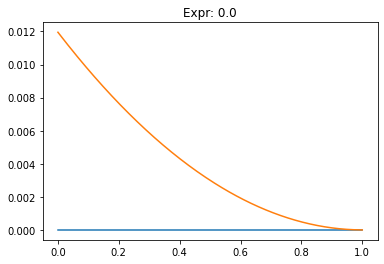

<Figure size 432x288 with 0 Axes>

In [6]:
pqc.train(1000)

In [18]:
print(input2[0])
pqc = PQCNN()
a = pqc.getPQCvector(input2[0])
v1 = []
for i in range(num):
    v1.append(pqc.getPQCvector(input1[i]).view(-1))
V1 = torch.stack(v1,0)
v2 = []
for i in range(num):
    v2.append(pqc.getPQCvector(input2[i]).view(-1))
V2 = torch.stack(v2,0)
F = torch.matmul(torch.conj(V1),torch.transpose(V2,0,1))
F = torch.abs(F)**2
F = torch.flatten(F)
print(F)
F.size()

tensor([2.0681, 3.5337, 0.5033, 0.0534, 0.2353, 3.9708])
tensor([0.1882, 0.0924, 0.2847, 0.0352, 0.2668, 0.5684, 0.0679, 0.1354, 0.1901,
        0.0043, 0.2020, 0.1905, 0.1587, 0.0902, 0.1991, 0.1699, 0.0700, 0.2556,
        0.3232, 0.0674, 0.1155, 0.2695, 0.0038, 0.2769, 0.4091, 0.3158, 0.0024,
        0.4708, 0.3784, 0.2285, 0.1970, 0.3695, 0.1208, 0.2017, 0.0755, 0.1523,
        0.1071, 0.4098, 0.2473, 0.2868, 0.1403, 0.4067, 0.1957, 0.2928, 0.0178,
        0.0425, 0.0138, 0.2368, 0.1211, 0.1080, 0.0099, 0.3737, 0.1858, 0.1375,
        0.0600, 0.1118, 0.0226, 0.0686, 0.0532, 0.0407, 0.2648, 0.5506, 0.2612,
        0.3411, 0.0140, 0.1031, 0.0614, 0.5010, 0.1947, 0.0956, 0.2860, 0.0494,
        0.8396, 0.0360, 0.4136, 0.2415, 0.6024, 0.1315, 0.2817, 0.1564, 0.3240,
        0.0395, 0.5067, 0.0786, 0.0616, 0.5468, 0.0471, 0.0591, 0.0184, 0.0494,
        0.0676, 0.0351, 0.0184, 0.0037, 0.0289, 0.0381, 0.1959, 0.1150, 0.1282,
        0.4792])


torch.Size([100])

In [11]:
print(torch.matmul(torch.transpose(input1,0,1),input2))

tensor([[1.6646, 1.1315, 1.3073, 1.1791, 2.4411, 2.0176, 1.0980, 0.7190, 1.0504,
         1.1639],
        [2.4842, 1.9447, 1.9468, 1.4523, 3.2830, 3.0344, 1.6524, 1.0257, 1.4880,
         1.4697],
        [1.9106, 1.7269, 1.5736, 1.5100, 2.8005, 2.5147, 1.4500, 0.9503, 1.0684,
         1.5353],
        [1.7895, 1.5102, 1.4119, 0.9302, 2.2537, 2.1048, 1.1559, 0.4776, 1.1899,
         1.2469],
        [1.6407, 1.1189, 1.3072, 1.5441, 2.7911, 2.3559, 1.3049, 0.9835, 1.0703,
         1.3252],
        [2.2978, 2.0493, 1.8470, 1.6618, 3.2957, 3.2093, 1.8058, 1.1537, 1.3881,
         1.6199],
        [2.1910, 1.5751, 1.7026, 1.2557, 2.9110, 2.5736, 1.3574, 0.7558, 1.4303,
         1.3632],
        [1.7646, 1.4380, 1.3217, 0.5973, 2.0959, 2.1084, 1.2590, 0.5339, 1.1214,
         0.9009],
        [2.0618, 1.6062, 1.6342, 1.3783, 2.9177, 2.5979, 1.3964, 0.6667, 1.4677,
         1.6186],
        [1.3130, 0.8030, 0.9899, 0.9173, 2.1216, 1.6799, 1.0812, 0.7004, 0.7974,
         0.9407]])
